In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import uproot
import awkward as ak
import concurrent.futures
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, ConcatDataset, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
class ParticleStaticEdgeConv(torch_geometric.nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(ParticleStaticEdgeConv, self).__init__(aggr='mean')
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, out_channels[0], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[0]), 
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels[0], out_channels[1], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels[1], out_channels[2], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[2]),
            torch.nn.ReLU()
        )

    def forward(self, x, edge_index, k):
        
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, edge_index, x_i, x_j):
        tmp = torch.cat([x_i, x_j - x_i], dim = 1)

        out_mlp = self.mlp(tmp)

        return out_mlp

    def update(self, aggr_out):
        return aggr_out

class ParticleDynamicEdgeConv(ParticleStaticEdgeConv):
    def __init__(self, in_channels, out_channels, k=7):
        super(ParticleDynamicEdgeConv, self).__init__(in_channels, out_channels)
        self.k = k
        self.skip_mlp = torch.nn.Sequential(
            torch.nn.Linear(in_channels, out_channels[2], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[2]),
        )
        self.act = torch.nn.ReLU()

    def forward(self, pts, fts, batch=None):
        edges = torch_geometric.nn.knn_graph(pts, self.k, batch, loop=False, flow=self.flow)
        aggrg = super(ParticleDynamicEdgeConv, self).forward(fts, edges, self.k)
        x = self.skip_mlp(fts)
        out = torch.add(aggrg, x)
        return self.act(out)


class ParticleNet(torch.nn.Module):

    def __init__(self, settings):
        super().__init__()
        previous_output_shape = settings['input_features']

        self.input_bn = torch_geometric.nn.BatchNorm(settings['input_features'])

        self.conv_process = torch.nn.ModuleList()
        for layer_idx, layer_param in enumerate(settings['conv_params']):
            K, channels = layer_param
            self.conv_process.append(ParticleDynamicEdgeConv(previous_output_shape, channels, k=K).to(DEVICE))
            previous_output_shape = channels[-1]



        self.fc_process = torch.nn.ModuleList()
        for layer_idx, layer_param in enumerate(settings['fc_params']):
            drop_rate, units = layer_param
            seq = torch.nn.Sequential(
                torch.nn.Linear(previous_output_shape, units),
                torch.nn.Dropout(p=drop_rate),
                torch.nn.ReLU()
            ).to(DEVICE)
            self.fc_process.append(seq)
            previous_output_shape = units


        self.output_mlp_linear = torch.nn.Linear(previous_output_shape, settings['output_classes'])
        self.output_activation = torch.nn.Softmax(dim=0)

    def forward(self, batch):
        fts = self.input_bn(batch.x)
        pts = batch.pos

        for idx, layer in enumerate(self.conv_process):
          fts = layer(pts, fts, batch.batch)
          pts = fts

        x = torch_geometric.nn.global_mean_pool(fts, batch.batch)

        for layer in self.fc_process:
            x = layer(x)

        x = self.output_mlp_linear(x)
        x = self.output_activation(x)
        return x

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = "cpu"
print(DEVICE)
settings = {
    "conv_params": [
        (16, (64, 64, 64)),
        (16, (128, 128, 128)),
        (16, (256, 256, 256)),
    ],
    "fc_params": [
        (0.1, 256)
    ],
    "input_features": 17,
    "output_classes": 1,
}

model = ParticleNet(settings)
print(model)

cuda
ParticleNet(
  (input_bn): BatchNorm(17)
  (conv_process): ModuleList(
    (0-2): 3 x ParticleDynamicEdgeConv()
  )
  (fc_process): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU()
    )
  )
  (output_mlp_linear): Linear(in_features=256, out_features=1, bias=True)
  (output_activation): Softmax(dim=0)
)


In [4]:
if DEVICE == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    print("GPU Name:", gpu_name)

GPU Name: NVIDIA RTX A6000


In [5]:
fileset = {}

sig_dir = '/mdsmlvol/rechits_v4/point_clouds/'
fileset['sample'] = [sig_dir + f'BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_{str(i).zfill(7)}_point_clouds.pt' for i in range(328)]
# fileset['sample'] = [sig_dir + f'BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_{str(i).zfill(7)}_point_clouds.pt' for i in range(10)]

# bkg_dir = '/ceph/cms/store/user/aaportel/B-Parking/rechits_v2/ParkingBPH1_2018A/'
# fileset['background'] = [bkg_dir + f'ParkingBPH1_2018A_{str(i).zfill(7)}.root' for i in range(380)]

In [6]:
shuffle_dataset = True
batch_size = 64
random_seed = 42
split_ratio = 0.8  # 80% of the data for training

# Assuming an even split of the remaining 20% for test and validation
test_validation_split_ratio = 0.5  # Split the remaining 20% evenly into test and validation

# Set random seed for reproducibility
torch.manual_seed(random_seed)

# Assuming 'fileset' and 'torch.load' are defined elsewhere in your code
datasets = [torch.load(fp) for fp in fileset['sample']]
dataset = ConcatDataset(datasets)

dataset_size = len(dataset)
train_size = int(split_ratio * dataset_size)
test_validation_size = dataset_size - train_size
test_size = int(test_validation_size * test_validation_split_ratio)
validation_size = test_validation_size - test_size

# Split the dataset into train, test, and validation sets
train_dataset, temp_test_validation_dataset = random_split(dataset, [train_size, test_validation_size])
test_dataset, validation_dataset = random_split(temp_test_validation_dataset, [test_size, validation_size])

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size, shuffle=shuffle_dataset)
test_loader = DataLoader(test_dataset, batch_size, shuffle=shuffle_dataset)
validation_loader = DataLoader(validation_dataset, batch_size, shuffle=shuffle_dataset)

In [44]:
# Define the training loop
def train(model, device, train_loader, optimizer):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, data.y.view(-1, 1).type_as(output))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Define the evaluation/testing loop
def evaluate(model, device, loader):
    model.eval()
    targets = []
    outputs = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            targets.extend(data.y.view(-1, 1).cpu().numpy())
            outputs.extend(output.cpu().numpy())

    return targets, outputs

# Define the validation loop
def validate(model, device, validation_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)
            output = model(data)
            loss = F.binary_cross_entropy(output, data.y.view(-1, 1).type_as(output))
            total_loss += loss.item()
    return total_loss / len(validation_loader)


# Setup optimizer
model = ParticleNet(settings)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to track the losses
train_losses = []
validation_losses = []

# Number of training epochs
epochs = 10

# Training loop
for epoch in range(epochs):
    train_loss = train(model, DEVICE, train_loader, optimizer)
    validation_loss = validate(model, DEVICE, validation_loader)
    
    # Record the losses for plotting
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')



Epoch 1, Train Loss: 1.6627
Epoch 2, Train Loss: 1.6525
Epoch 3, Train Loss: 1.6502
Epoch 4, Train Loss: 1.6487
Epoch 5, Train Loss: 1.6479
Epoch 6, Train Loss: 1.6463
Epoch 7, Train Loss: 1.6457
Epoch 8, Train Loss: 1.6451


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR

# Define the training loop with scheduler step
def train(model, device, train_loader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)  # Ensure your model outputs are correctly aligned with the targets
        loss = F.binary_cross_entropy(output, data.y.view(-1, 1).type_as(output))  # Ensure this matches your data structure
        loss.backward()
        optimizer.step()
        scheduler.step()  # Step the scheduler after each batch
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Define the evaluation/testing loop
def evaluate(model, device, loader):
    model.eval()
    targets = []
    outputs = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            targets.extend(data.y.view(-1, 1).cpu().numpy())  # Ensure this matches your data structure
            outputs.extend(output.cpu().numpy())

    return targets, outputs

# Define the validation loop
def validate(model, device, validation_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)
            output = model(data)
            loss = F.binary_cross_entropy(output, data.y.view(-1, 1).type_as(output))  # Ensure this matches your data structure
            total_loss += loss.item()
    return total_loss / len(validation_loader)

# Setup optimizer with weight decay
model = ParticleNet(settings)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

epochs = 20
# Setup OneCycleLR scheduler with the parameters according to the documentation
scheduler = OneCycleLR(optimizer, max_lr=3e-3, epochs=epochs, steps_per_epoch=len(train_loader), pct_start=0.5, anneal_strategy='linear', final_div_factor=1e4/3e-4)

# Initialize lists to track the losses
train_losses = []
validation_losses = []

# Training loop
for epoch in range(epochs):
    train_loss = train(model, DEVICE, train_loader, optimizer, scheduler)  # Pass scheduler here
    validation_loss = validate(model, DEVICE, validation_loader)
    
    # Record the losses for plotting
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')


Epoch 1, Train Loss: 1.6719, Validation Loss: 1.6222
Epoch 2, Train Loss: 1.6553, Validation Loss: 1.6173
Epoch 3, Train Loss: 1.6527, Validation Loss: 1.6221
Epoch 4, Train Loss: 1.6519, Validation Loss: 1.6196
Epoch 5, Train Loss: 1.6522, Validation Loss: 1.6240
Epoch 6, Train Loss: 1.6519, Validation Loss: 1.6153
Epoch 7, Train Loss: 1.6504, Validation Loss: 1.6151
Epoch 8, Train Loss: 1.6507, Validation Loss: 1.6163
Epoch 9, Train Loss: 1.6504, Validation Loss: 1.6174
Epoch 10, Train Loss: 1.6497, Validation Loss: 1.6172
Epoch 11, Train Loss: 1.6488, Validation Loss: 1.6179
Epoch 12, Train Loss: 1.6481, Validation Loss: 1.6159


In [ ]:
# After training, plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

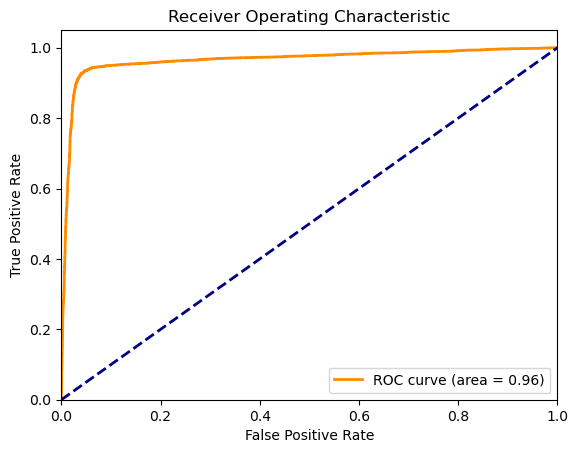

In [25]:
# Evaluation on the test set
targets, outputs = evaluate(model, DEVICE, validation_loader)

# Compute ROC curve and ROC area
targets = np.array(targets)
outputs = np.array(outputs)
fpr, tpr, _ = roc_curve(targets, outputs)
roc_auc = roc_auc_score(targets, outputs)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()